In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2.12.0


In [4]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = 'train-data.tsv'
test_file_path = 'valid-data.tsv'

--2023-08-07 18:06:25--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1    100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2023-08-07 18:06:26 (8.38 MB/s) - ‘train-data.tsv.1’ saved [358233/358233]

--2023-08-07 18:06:26--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[======

In [5]:
df_train = pd.read_csv(train_file_path, sep='\t', header=None, names=['y','x'])
df_train.head()

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [6]:
df_test = pd.read_csv(test_file_path, sep='\t', header=None, names=['y','x'])
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [7]:
# organize categorical values and labels
train_y = df_train['y'].astype('category').cat.codes
test_y = df_test['y'].astype('category').cat.codes
train_y[:5]

0    0
1    0
2    0
3    0
4    0
dtype: int8

Text(0, 0.5, 'Number of Messages Sent')

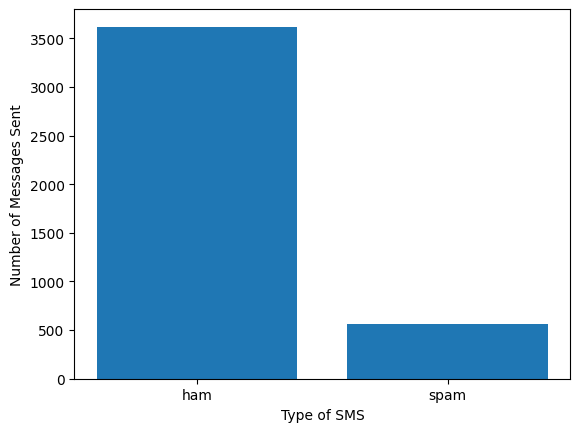

In [8]:
# visualize data
bar_graph = df_train['y'].value_counts()
plt.bar(bar_graph.index, bar_graph)
plt.xlabel('Type of SMS')
plt.ylabel('Number of Messages Sent')

In [9]:
# process text with a package for natural language processing
import nltk
nltk.download('stopwords')
nltk.download('wordnet') # download vocab for lemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [12]:
eng_sw = set(stopwords.words('english'))
len(eng_sw)

179

In [13]:
# reduce inflected words to their root word
lemma = WordNetLemmatizer()
def reduce(txt):
  txt = re.sub(r'([^\s\w])+', ' ', txt)
  txt = ' '.join([lemma.lemmatize(word) for word in txt.split() if not word in eng_sw])
  txt = txt.lower()
  return txt

In [15]:
# organize and clean
train_x = df_train['x'].apply(lambda x: reduce(x))
train_x[:5]

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: x, dtype: object

In [16]:
# converting input data from its raw format (text) into vectors of real numbers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences

In [17]:
# keep top 1000 most common words
common_w = 1000
# after 500 words in each, stop readin
stop_len = 500

t = Tokenizer(num_words = common_w)
t.fit_on_texts(train_x)

In [18]:
# vectorize english into numbers
sequences = t.texts_to_sequences(train_x)
sequences[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [19]:
# distribute rows
sequences_matrix = pad_sequences(sequences, maxlen=stop_len)
sequences_matrix[:5]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]], dtype=int32)

In [23]:
# create keras sequential model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[stop_len]),
    tf.keras.layers.Embedding(common_w, 50, input_length=stop_len),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 50)           50000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


In [24]:
e = model.fit(sequences_matrix,
              train_y,
              batch_size = 128,
              epochs = 10,
              validation_split = 0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
27/27 [==============================] - 33s 1s/step - loss: 0.3585 - accuracy: 0.8806 - val_loss: 0.2061 - val_accuracy: 0.9426
Epoch 2/10
27/27 [==============================] - 26s 953ms/step - loss: 0.1312 - accuracy: 0.9746 - val_loss: 0.1206 - val_accuracy: 0.9797
Epoch 3/10
27/27 [==============================] - 26s 969ms/step - loss: 0.0801 - accuracy: 0.9871 - val_loss: 0.0994 - val_accuracy: 0.9880
Epoch 4/10
27/27 [==============================] - 26s 965ms/step - loss: 0.0702 - accuracy: 0.9913 - val_loss: 0.1146 - val_accuracy: 0.9892


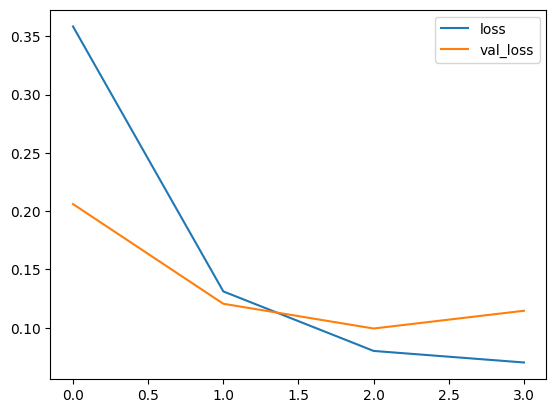

In [25]:
# evaluate model performance
plt.plot(e.history['loss'], label='loss')
plt.plot(e.history['val_loss'], label='val_loss')
plt.legend()

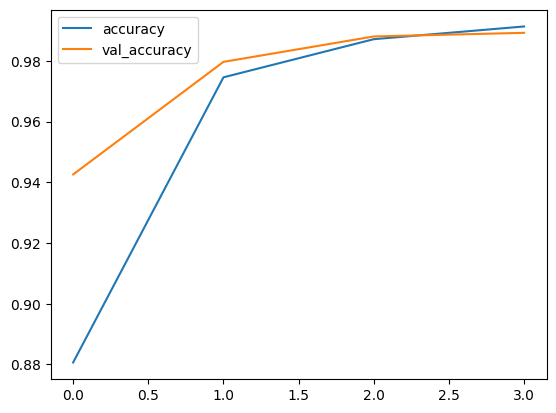

In [26]:
plt.plot(e.history['accuracy'], label='accuracy')
plt.plot(e.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [27]:
def summary(w):
  x = w.apply(lambda x: reduce(x))
  x = t.texts_to_sequences(x)
  return pad_sequences(x, maxlen=stop_len)

In [28]:
f = model.evaluate(summary(df_test['x']), test_y)

44/44 [==============================] - 4s 94ms/step - loss: 0.0816 - accuracy: 0.9864


In [29]:
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(f[0], f[1]))

Loss: 0.082, Accuracy: 0.986


In [30]:
# function to predict messages based on model
# should return list containing prediction and label
def predict_message(pred_text):
  p = model.predict(summary(pd.Series([pred_text])))[0]
  return (p[0], ('ham' if p<0.5 else 'spam'))

pred_text = 'how are you doing today?'

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 1s 701ms/step
(0.0, 'ham')


In [31]:
# run this cell to test your function and model, do not modify contents
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                   ]
  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed= True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 59ms/step
You passed the challenge. Great job!
